# Notebook: Joining Multiple Tables via pandas DataFrames
This Jupyter notebook demonstrates how to join a table that is fragmented across multiple pages.

For a short and appealing presentation of the topic we use the following Python packages beyond PyMuPDF itself. Please note that they are not required to use the table feature itself.

* [matplotlib](https://pypi.org/project/matplotlib/)
* [pandas](https://pypi.org/project/pandas/)

Please check the following list of package installations. These packages ae needed to run this notebook. In case your local configuration is not complete, just un-comment the respective line before using "Run All".

In [1]:
# un-comment any of the following:
#!python -m pip install pymupdf
#!python -m pip install matplotlib
#!python -m pip install pandas
#!python -m pip install numpy

The following function is used for displaying PyMuPDF Pixmaps inline within this notebook. Just technical stuff and not important for understanding the purpose of the document.

In [2]:
"""
Utility function for showing images.

Intended to be imported in Jupyter notebooks to display pixmap images.

Invocation: "show_image(item, title)", where item is a PyMuPDF object
which has a "get_pixmap" method, and title is an optional string.

The function executes "item.get_pixmap(dpi=150)" and show the resulting
image.


Dependencies
------------
numpy, matplotlib, pymupdf
"""


def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    import numpy as np
    import matplotlib.pyplot as plt

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

In [3]:
import pandas as pd  # import pandas
import fitz  # import PyMuPDF
if not hasattr(fitz.Page, "find_tables"):
    raise RuntimeError("This PyMuPDF version does not support the table feature")

# Open Example Document and Show the First Page
This demonstrates the concatenation (merging) of parts of the same table that has b een split across multiple pages.

The file lists national capital cities of the world. From each page, we extract a table fragment, convert it to a pandas DataFrame which we append to a list.

At end of input pages (or when encountering a page with no tables), we concatenate the DataFrames into a final one.

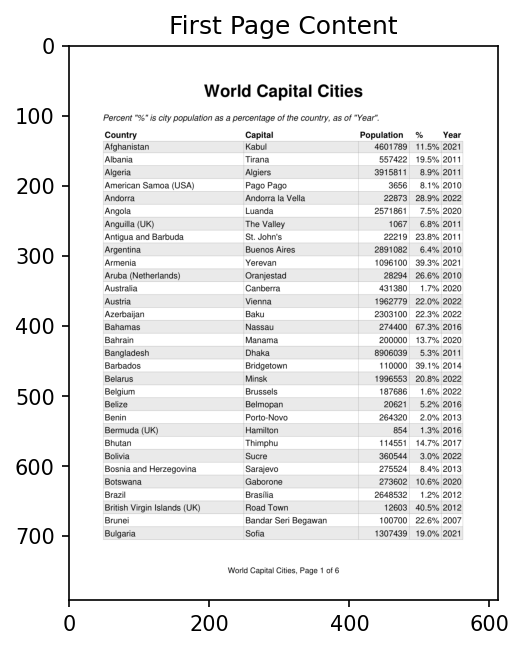

In [4]:
doc = fitz.open("national-capitals.pdf")  # open example file
page = doc[0]  # read first page to demo the layout
show_image(page,"First Page Content")

## Extract Table Fragments and Join them in a DataFrame

In [5]:
dataframes = []  # list of DataFrames per table fragment

for page in doc:  # iterate over the pages
    tabs = page.find_tables()  # locate tables on page
    if len(tabs.tables) == []:  # no tables found?
        break  # stop
    tab = tabs[0]  # assume fragment to be 1st table
    dataframes.append(tab.to_pandas())  # append this DataFrame

df = pd.concat(dataframes)  # make concatenated DataFrame
df  # show it

,Country,Capital,Population,%,Year
0,Afghanistan,Kabul,4601789,11.5%,2021
1,Albania,Tirana,557422,19.5%,2011
2,Algeria,Algiers,3915811,8.9%,2011
3,American Samoa (USA),Pago Pago,3656,8.1%,2010
4,Andorra,Andorra la Vella,22873,28.9%,2022
...,...,...,...,...,...
28,Wallis and Futuna (France),Mata Utu,1029,8.9%,2018
29,Yemen,Sanaa,2575347,7.8%,2012
30,Zambia,Lusaka,2731696,14.0%,2020
31,Zimbabwe,Harare,2123132,13.3%,2012


## Extract Table Fragments and Join them in a List
Joining table fragments without using pandas is not difficult either. We simply join the lists of extracted cell text per page.

Here we also check whether the continuation table has indeed the same column header names.

In [8]:
names0 = None  # column names for comparison purposes
all_extracts = []  # all table rows go here

for page in doc:  # iterate over the pages
    tabs = page.find_tables()  # find tables on page
    if tabs.tables == []:  # a page without table: stop processing
        break
    tab = tabs[0]  # access first table
    header = tab.header  # get its header
    external = header.external  # header outside table body?
    names = header.names  # column names
    if page.number == 0:  # on first page, store away column names
        names0 = names
    elif names != names0:  # not our table anymore
        break
    extract = tab.extract()  # get text for all table cells
    if not external:  # if header contained in table body 
        extract = extract[1:]  # omit repeating header row
    all_extracts.extend(extract)  # append to total list

print(f"The joined table has {len(all_extracts)} rows and {len(names0)} columns.\n")
print(names0)
for i, r in enumerate(all_extracts):
    print(r)
    if i >= 10:
        print("...")
        break


The joined table has 204 rows and 5 columns.

['Country', 'Capital', 'Population', '%', 'Year']
['Afghanistan', 'Kabul', '4601789', '11.5%', '2021']
['Albania', 'Tirana', '557422', '19.5%', '2011']
['Algeria', 'Algiers', '3915811', '8.9%', '2011']
['American Samoa (USA)', 'Pago Pago', '3656', '8.1%', '2010']
['Andorra', 'Andorra la Vella', '22873', '28.9%', '2022']
['Angola', 'Luanda', '2571861', '7.5%', '2020']
['Anguilla (UK)', 'The Valley', '1067', '6.8%', '2011']
['Antigua and Barbuda', "St. John's", '22219', '23.8%', '2011']
['Argentina', 'Buenos Aires', '2891082', '6.4%', '2010']
['Armenia', 'Yerevan', '1096100', '39.3%', '2021']
['Aruba (Netherlands)', 'Oranjestad', '28294', '26.6%', '2010']
...
